# Part 2: Feature Engineering

In [20]:
# Standard
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

# Datapath and Setup
data_path = "C:/Users/Sadek/Documents/GitHub/Project/telecom-customer-churn/data/"

from sklearn.compose import make_column_selector as selector

# Helper functions for structured data
# Correlation analysis
def correlation_heatmap(dataset):
    # Correlation between different variables
    corr = dataset.corr()
    # Set up the matplotlib plot configuration
    f, ax = plt.subplots(figsize=(5, 5))
    # Generate a mask for upper traingle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)

# 1. Load Data

In [2]:
dataset = pd.read_csv(data_path+"WA_Fn-UseC_-Telco-Customer-Churn.csv")
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors="coerce")
dataset.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


# 2. Data preparation and feature engineering

## 2.1. Basic Feature Engineering

In [3]:
idcol = 'customerID'  # ID column
labelcol = 'Churn'  # label column

In our dataset, the `customerID` is unique for each row and does not bring us relevant information for an analysis, so we can remove itped.

In [4]:
dataset = dataset.drop([idcol], axis=1)
dataset.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


In [5]:
dataset = dataset.replace(r'^\s$', np.nan, regex=True).dropna()  # drop blank rows, in this dataset there's not one
dataset.index.name = 'id'  # name the index

In [6]:
dataset.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


Then, we'll split the dataset in order to have the target separated form the data.

In [7]:
target_name = labelcol
target = dataset[target_name]
data = dataset.drop(columns=target_name)

In [8]:
target = (target == 'Yes')  # convert labels from str to bool

This step follows a fairly standard ML workflow, which is to create a pipeline to:

* Select features based on their data type (numerical or categorical)
* Encode the categorical features as numeric, as ML models works only with numerical values
* Normalize the numeric features it's required (depends of ML algorithm family )

For logistic regression model, normalization is not required, but the main goal of standardizing features is to help convergence of the technique used for optimization.\
Logistic regression requires normalization as well in order to avoid the vanishing gradient problem during the training phase.\
We'll use `one-hot encoding` for categorical features and `standardization` for numerical features.

And for tree-based model like `Hist Gradient Boosting Classifier`:

* Numerical variables don’t need scaling;
* Categorical variables can be dealt with an OrdinalEncoder even if the coding order is not meaningful;

But, before proceeding, will be converted `SeniorCitizen` to categorical in order to match the other binary features.

In [9]:
data = data.replace({'SeniorCitizen': {1: 'Yes', 0: 'No'}})  # Change 1/0 to Yes/No to match the other binary features

## 2.2. Numerical Features

In [10]:
numerical_columns_selector = selector(dtype_include=np.number)
numerical_columns = numerical_columns_selector(data)
print(f"Number of numerical features: {len(numerical_columns)}")
print(30*"=")
for feature in numerical_columns:
    print(f"{feature}")

Number of numerical features: 3
tenure
MonthlyCharges
TotalCharges


In [11]:
# Printing some statistics about numerical features
data[numerical_columns].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


We see that the dataset’s features span across different ranges. Some algorithms make some assumptions regarding the feature distributions and usually normalizing features will be helpful to address these assumptions.

So, by scaling, we'll shifts and scales each feature individually so that they all have a `0-mean` and a `unit standard deviation`.

In [16]:
scaler = StandardScaler()
scaler.fit(data[numerical_columns])

StandardScaler()

In [17]:
print(scaler.mean_)
print(scaler.scale_)

[  32.42178612   64.79820819 2283.30044084]
[  24.54351439   30.08383459 2266.61018071]


In [18]:
data_scaled = scaler.transform(data[numerical_columns])
data_scaled

array([[-1.28024804, -1.16169394, -0.99419409],
       [ 0.06430269, -0.26087792, -0.17373982],
       [-1.23950408, -0.36392329, -0.95964911],
       ...,
       [-0.87280842, -1.17000405, -0.85451414],
       [-1.15801615,  0.31916782, -0.87209546],
       [ 1.36810945,  1.35793167,  2.01234407]])

In [19]:
data_train_scaled = pd.DataFrame(data_scaled,
                                 columns=numerical_columns)
data_train_scaled.describe()

,tenure,MonthlyCharges,TotalCharges
count,7.032000e+03,7.032000e+03,7.032000e+03
mean,-1.214741e-16,9.652878e-17,-1.172113e-16
std,1.000071e+00,1.000071e+00,1.000071e+00
min,-1.280248e+00,-1.547283e+00,-9.990692e-01
25%,-9.542963e-01,-9.709769e-01,-8.302488e-01
50%,-1.394171e-01,1.845440e-01,-3.908151e-01
75%,9.199259e-01,8.331482e-01,6.668271e-01
max,1.612573e+00,1.793381e+00,2.824261e+00


Notice that the mean of all the columns is close to 0 and the standard deviation in all cases is close to 1. 

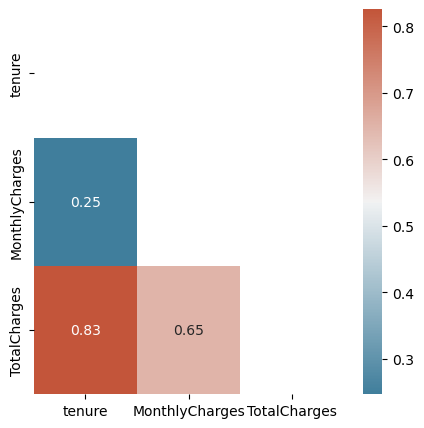

In [12]:
correlation_heatmap(data[numerical_columns])

The features `Tenure` and `TotalCharges` are strongly correlated, which means that as one increases the other increases as well. It is not very interesting to work with two correlated features. For further steps, `TotalCharges` will be removed because it has also a strong correlation with `MonthlyCharges`.\
In addition, `TotalCharges` contains month information from `ChargesMonthly` multiplied by `Tenure`, so it is "duplicate" information.

## 2.3. Categorical Features

In [13]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
print(f"Number of categorical features: {len(categorical_columns)}")
print(30*"=")
for feature in categorical_columns:
    print(f"{feature}")

Number of categorical features: 16
gender
SeniorCitizen
Partner
Dependents
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod


Now let's check the features that can contain more than two labels.

In [14]:
for feature in data[categorical_columns]:
    if(len(data[feature].unique()) > 2):
        print(f"{feature}: {data[feature].unique()}")

MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Some features have the class `No phone service` and `No internet service` that is equivalent to the class `No`. So, they’ll be replaced by `No`.

In [15]:
data = data.replace(regex=r'No.*service', value='No')